In [ ]:
pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [1]:
pip install matplotlib pillow numpy


In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [3]:
class ESRGANDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform_lr=None, transform_hr=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
        self.transform_lr = transform_lr
        self.transform_hr = transform_hr

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_images[idx])

        lr_image = Image.open(lr_path).convert('RGB')
        hr_image = Image.open(hr_path).convert('RGB')

        if self.transform_lr:
            lr_image = self.transform_lr(lr_image)
        if self.transform_hr:
            hr_image = self.transform_hr(hr_image)

        return lr_image, hr_image


In [4]:
# Common size for cropping to ensure divisible by 4
crop_size = 96

transform_hr = transforms.Compose([
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
])

transform_lr = transforms.Compose([
    transforms.CenterCrop(crop_size // 4),
    transforms.Resize(crop_size),  # Upsample to match HR size for training
    transforms.ToTensor(),
])


In [5]:
lr_train_path = "/content/drive/MyDrive/data/DIV2K_train_LR_bicubic/DIV2K_train_LR_bicubic/X4"
hr_train_path = "/content/drive/MyDrive/data/DIV2K_train_HR/DIV2K_train_HR"

lr_test_path = "/content/drive/MyDrive/data/DIV2K_valid_LR_bicubic/DIV2K_valid_LR_bicubic/X4"
hr_test_path = "/content/drive/MyDrive/data/DIV2K_valid_HR/DIV2K_valid_HR"


In [6]:
# Train Dataset and Loader
train_dataset = ESRGANDataset(lr_train_path, hr_train_path, transform_lr, transform_hr)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Test Dataset and Loader
test_dataset = ESRGANDataset(lr_test_path, hr_test_path, transform_lr, transform_hr)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


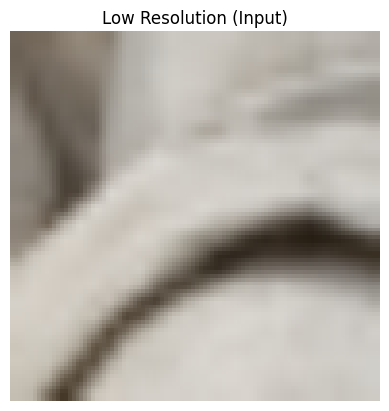

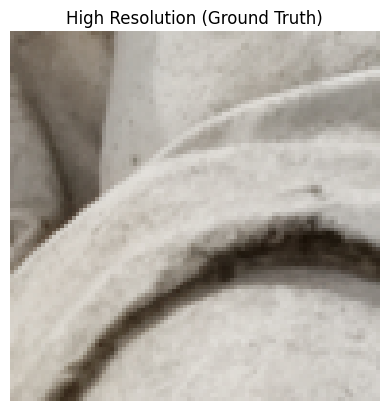

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(tensor, title):
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")

# View first batch from training data
lr_imgs, hr_imgs = next(iter(train_loader))
imshow(lr_imgs[2], title="Low Resolution (Input)")
plt.figure()
imshow(hr_imgs[2], title="High Resolution (Ground Truth)")



In [8]:
import torch
import torch.nn as nn

class RRDB(nn.Module):
    def __init__(self, in_channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        return x + out  # Residual connection

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_rrdb=23):
        super(Generator, self).__init__()
        self.initial_conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])
        self.final_conv = nn.Conv2d(64, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        initial_feature = self.initial_conv(x)
        out = self.rrdb_blocks(initial_feature)
        out = self.final_conv(out)
        return out

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, 64, normalize=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 3, stride=1, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [10]:
import torch.nn.functional as F

class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()

    def forward(self, sr, hr):
        return F.mse_loss(sr, hr)

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_model):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg_model.features[:36]  # Use pre-trained VGG features
        self.vgg.eval()

    def forward(self, sr, hr):
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)
        return F.mse_loss(sr_features, hr_features)

In [15]:
def train(generator, discriminator, dataloader, num_epochs, optimizer_G, optimizer_D, criterion_content, criterion_perceptual):
    for epoch in range(num_epochs):
        for i, (lr_img, hr_img) in enumerate(dataloader):
    # Train Generator
          optimizer_G.zero_grad()
          sr_image = generator(lr_img)  # input LR, output SR

          content_loss = criterion_content(sr_image, hr_img)
          perceptual_loss = criterion_perceptual(sr_image, hr_img)
          g_loss = content_loss + perceptual_loss
          g_loss.backward()
          optimizer_G.step()

    # Train Discriminator
          optimizer_D.zero_grad()
          real_output = discriminator(hr_img)
          fake_output = discriminator(sr_image.detach())
          d_loss = F.binary_cross_entropy_with_logits(real_output, torch.ones_like(real_output)) + \
                   F.binary_cross_entropy_with_logits(fake_output, torch.zeros_like(fake_output))
          d_loss.backward()
          optimizer_D.step()

          if i % 10 == 0:
             print(f"Epoch {epoch}/{num_epochs}, Step {i}, G Loss: {g_loss.item()}, D Loss: {d_loss.item()}")


In [16]:
def upscale_image(generator, lr_image):
    generator.eval()
    with torch.no_grad():
        sr_image = generator(lr_image)
    return sr_image

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim

# Initialize Generator, Discriminator, and Optimizers
generator = Generator()
discriminator = Discriminator()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

from torchvision.models import vgg19, VGG19_Weights

weights = VGG19_Weights.DEFAULT
vgg = vgg19(weights=weights)
vgg = vgg.to(device)

# Load pre-trained VGG model for Perceptual Loss

criterion_content = ContentLoss()
criterion_perceptual = PerceptualLoss(vgg)

# Train ESRGAN
train(generator, discriminator, dataloader=train_loader, num_epochs=2, optimizer_G=optimizer_G, optimizer_D=optimizer_D,
      criterion_content=criterion_content, criterion_perceptual=criterion_perceptual)

Epoch 0/2, Step 0, G Loss: 0.3881469964981079, D Loss: 1.4166476726531982
Epoch 0/2, Step 10, G Loss: 0.226074680685997, D Loss: 1.1234102249145508
Epoch 0/2, Step 20, G Loss: 0.27743855118751526, D Loss: 0.6811422109603882
Epoch 1/2, Step 0, G Loss: 0.2304050475358963, D Loss: 0.5387241840362549
Epoch 1/2, Step 10, G Loss: 0.18924185633659363, D Loss: 0.47859513759613037
Epoch 1/2, Step 20, G Loss: 0.2194371223449707, D Loss: 0.19133299589157104


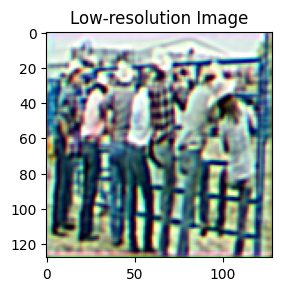

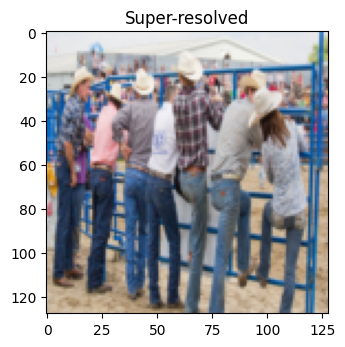

In [23]:
from torchvision.utils import save_image

# Load a test image
test_image = Image.open("/content/drive/MyDrive/data/DIV2K_valid_LR_bicubic/DIV2K_valid_LR_bicubic/X4/0804x4.png").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

test_image = transform(test_image).unsqueeze(0).to(device)

# Generate super-resolved image
generator.eval()
with torch.no_grad():
    sr_image = generator(test_image)

# Save and Display Results
save_image(sr_image, "sr_image.png")
save_image(test_image, "lr_image.png")

plt.subplot(1, 2, 2)
plt.title("Low-resolution Image")
plt.imshow(np.transpose(sr_image.squeeze().cpu().numpy(), (1, 2, 0)))
plt.show()
# Show images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Super-resolved")
plt.imshow(np.transpose(test_image.squeeze().cpu().numpy(), (1, 2, 0)))
